In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
from utils import validate_segmentation, plot_prediction, dice_score
from torchvision.transforms import functional as TF
from torch.autograd import Variable
from tqdm import tqdm
import random
import cv2
import torchio as tio
from pathlib import Path
import seaborn as sns
import copy

#check if colab is being used
if os.path.exists('/content'):
    print('Running on CoLab')
    from google.colab import drive
    drive.mount('/content/drive')
    torch.cuda.empty_cache()

path_to_mask = 'data/patients/labels/'
path_to_imgs = 'data/patients/imgs/'
path_to_controls = 'data/controls/imgs/' #healthy individuals (no tumors)
dataset_path = 'data.zip'
dataset_dir_name = 'data'
dataset_dir = Path(dataset_dir_name)

if not dataset_dir.is_dir():
    !curl --silent --output {dataset_path} --location {dataset_url} 
    !unzip -qq {dataset_path}
!tree -d {dataset_dir_name}

print(dataset_dir)

/home/asp/anaconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


data
├── controls
│   └── imgs
└── patients
    ├── imgs
    └── labels

5 directories
data


## Reading image data

In [2]:
images_dir = dataset_dir / 'patients/imgs'
print(images_dir)
labels_dir = dataset_dir / 'patients/labels'
controls_dir = dataset_dir / 'controls/imgs'
image_paths = sorted(images_dir.glob('*.png'))
label_paths = sorted(labels_dir.glob('*.png'))
control_paths = sorted(controls_dir.glob('*.png'))
assert len(image_paths) == len(label_paths)

subjects = []
for (image_path, label_path) in zip(image_paths, label_paths):
    subject = tio.Subject(
        img=tio.ScalarImage(image_path),
        label=tio.LabelMap(label_path),
    )
    subjects.append(subject)

dataset = tio.SubjectsDataset(subjects)

print('Dataset size:', len(dataset), 'subjects')

data/patients/imgs
Dataset size: 182 subjects


Subject: Subject(Keys: ('img', 'label'); images: 2)
Image: ScalarImage(shape: (4, 400, 489, 1); spacing: (1.00, 1.00, 1.00); orientation: LPS+; dtype: torch.ByteTensor; memory: 764.1 KiB)
Label: LabelMap(shape: (4, 400, 489, 1); spacing: (1.00, 1.00, 1.00); orientation: LPS+; dtype: torch.ByteTensor; memory: 764.1 KiB)


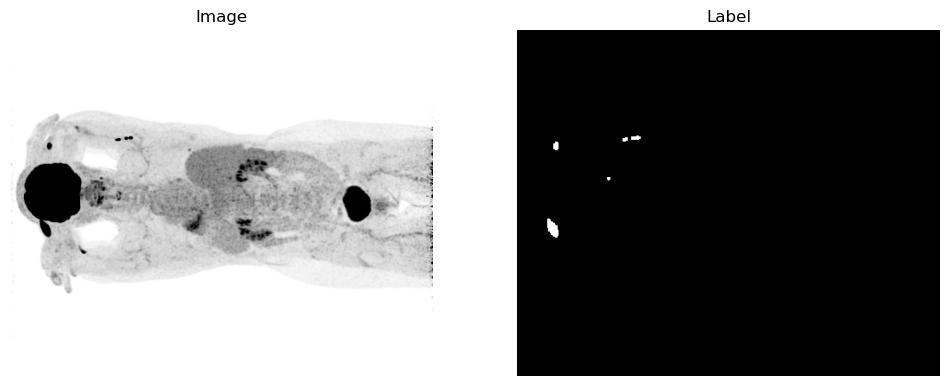

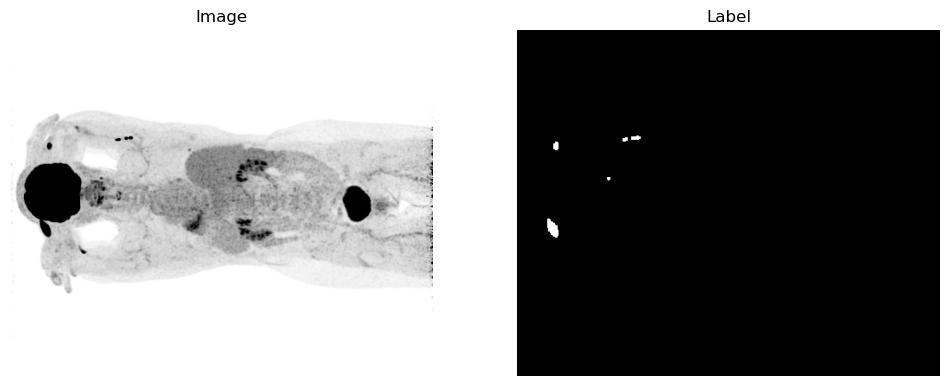

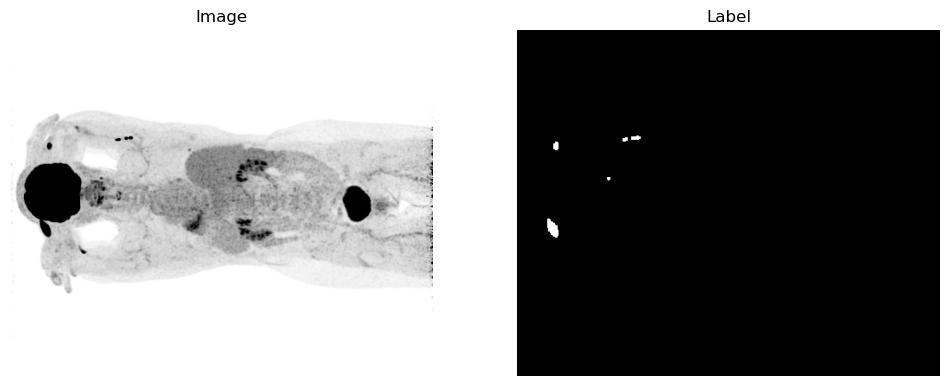

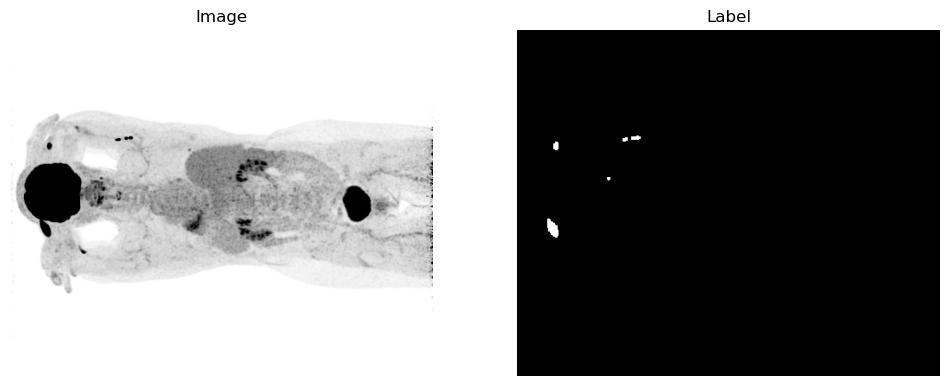

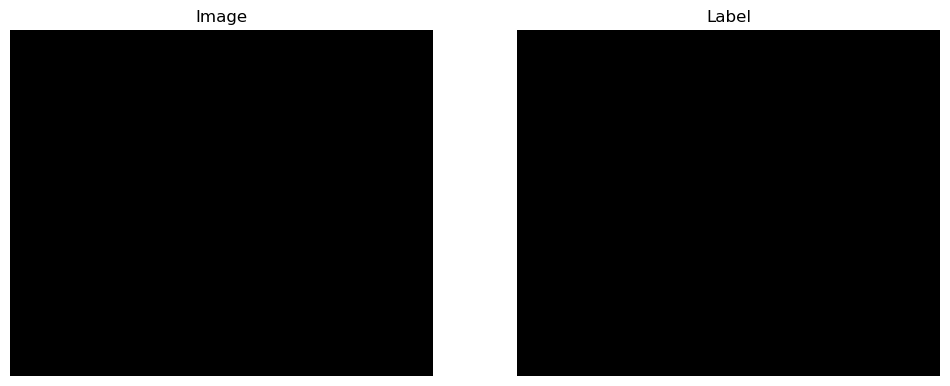

In [3]:
one_subject = dataset[0]

print('Subject:', one_subject)
print('Image:', one_subject.img)
print('Label:', one_subject.label)

# Extracting the image and label arrays
image_array = one_subject['img'][tio.DATA].squeeze().numpy()  # Assuming 'img' is the key for images
label_array = one_subject['label'][tio.DATA].squeeze().numpy()  # Assuming 'label' is the key for labels

# Choosing a slice to display, for example, the middle slice
slice_idx = image_array.shape[0] // 2
image_slice = image_array[slice_idx, :, :]
label_slice = label_array[slice_idx, :, :]

def plot_example(image_slice, label_slice):
    # Plotting the images
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image_slice, cmap='gray')
    axes[0].set_title('Image')
    axes[0].axis('off')

    axes[1].imshow(label_slice, cmap='gray')
    axes[1].set_title('Label')
    axes[1].axis('off')

    plt.show()

plot_example(image_slice, label_slice)
plot_example(image_array[0, :, :], label_array[0, :, :])
plot_example(image_array[1, :, :], label_array[1, :, :])
plot_example(image_array[2, :, :], label_array[2, :, :])
plot_example(image_array[3, :, :], label_array[3, :, :])


(4, 400, 489)


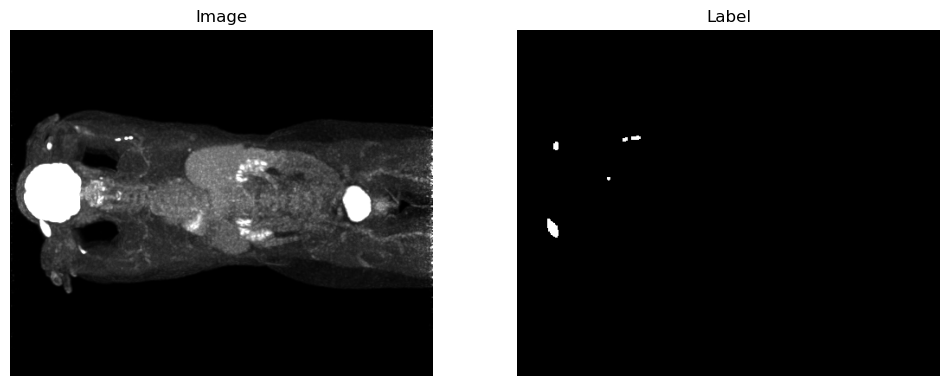

In [4]:
# Assuming the images are 8-bit, maximum value would be 255
max_value = 255 # 1 looks very interesting...

print(image_array.shape)

# Inverting the image array
inverted_image_array = max_value - image_array

# Convert the numpy array back to a Tensor with the correct shape
inverted_image_tensor = torch.from_numpy(inverted_image_array).to(torch.uint8)  # Ensure the data type is correct

# Updating the one_subject object with the inverted image and original label
one_subject['img'][tio.DATA] = inverted_image_tensor.unsqueeze(-1)
one_subject['label'][tio.DATA] = torch.from_numpy(label_array).unsqueeze(-1)  # Ensure label array is correctly formatted

image_array = one_subject.img[tio.DATA].squeeze().numpy()
label_array = one_subject.label[tio.DATA].squeeze().numpy()

slice_idx = image_array.shape[0] // 2
image_slice = image_array[slice_idx, :, :]
label_slice = label_array[slice_idx, :, :]

plot_example(image_slice, label_slice)

## Preprocessing the images

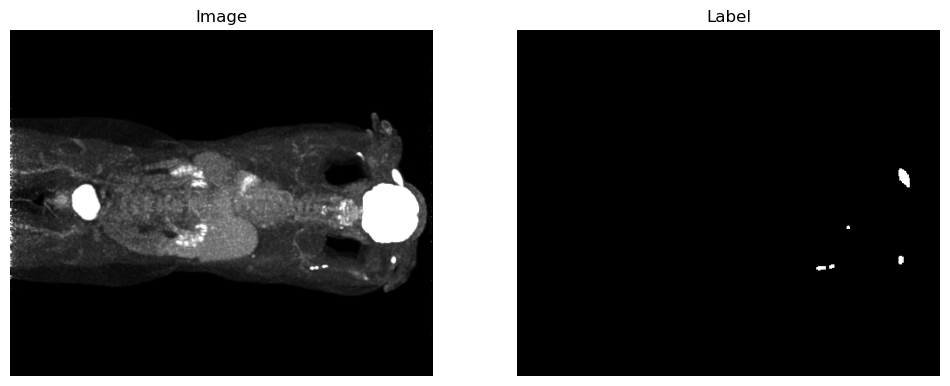

In [5]:
# to canonical

to_canonical = tio.ToCanonical()
subject_canonical = to_canonical(one_subject)

plot_example(subject_canonical['img'][tio.DATA].squeeze().numpy()[slice_idx, :, :],
                subject_canonical['label'][tio.DATA].squeeze().numpy()[slice_idx, :, :])


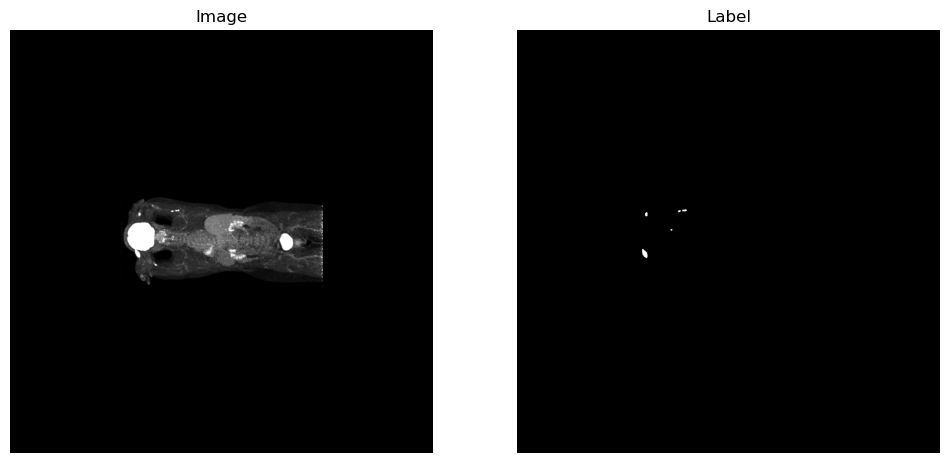

In [6]:
# crop or pad

target_shape = 1024, 1024, 1 # good size for U-Net
cropper = tio.CropOrPad(target_shape)
subject_cropped = cropper(one_subject)

plot_example(subject_cropped['img'][tio.DATA].squeeze().numpy()[slice_idx, :, :],
                subject_cropped['label'][tio.DATA].squeeze().numpy()[slice_idx, :, :])

## Augmentation

/home/asp/anaconda3/lib/python3.11/site-packages/torchio/transforms/transform.py:163: RuntimeWarning: Input image is 2D, but "2" is in axes: (0, 1, 2)
  transformed = self.apply_transform(subject)


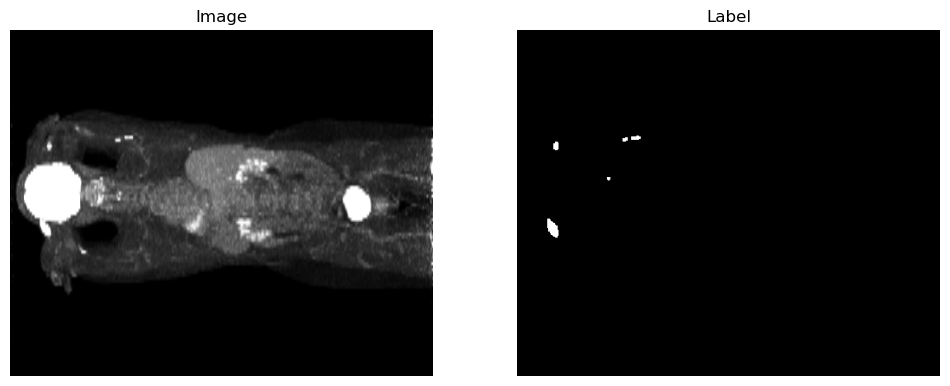

In [7]:
# random anisotropy

anisotropy = tio.RandomAnisotropy()
subject_anisotropy = anisotropy(one_subject)

plot_example(subject_anisotropy['img'][tio.DATA].squeeze().numpy()[slice_idx, :, :],
                subject_anisotropy['label'][tio.DATA].squeeze().numpy()[slice_idx, :, :])

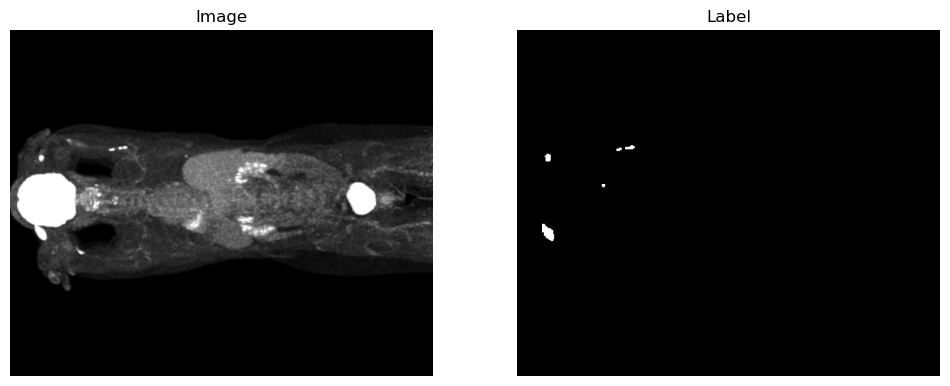

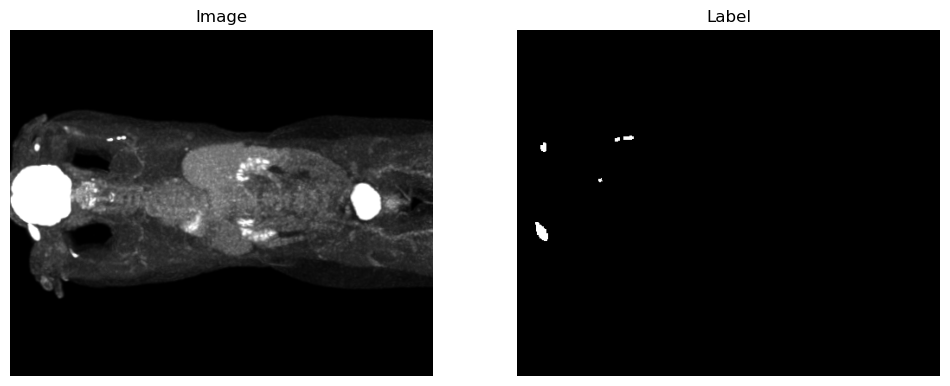

In [8]:
# random affine

random_affine = tio.RandomAffine()
subject_affine = random_affine(one_subject)

plot_example(subject_affine['img'][tio.DATA].squeeze().numpy()[slice_idx, :, :],
                subject_affine['label'][tio.DATA].squeeze().numpy()[slice_idx, :, :])

random_affine_zoom = tio.RandomAffine(scales=(0.9, 1.1),
                                      degrees=(-2,2))
subject_affine_zoom = random_affine_zoom(one_subject)

plot_example(subject_affine_zoom['img'][tio.DATA].squeeze().numpy()[slice_idx, :, :],
                subject_affine_zoom['label'][tio.DATA].squeeze().numpy()[slice_idx, :, :])

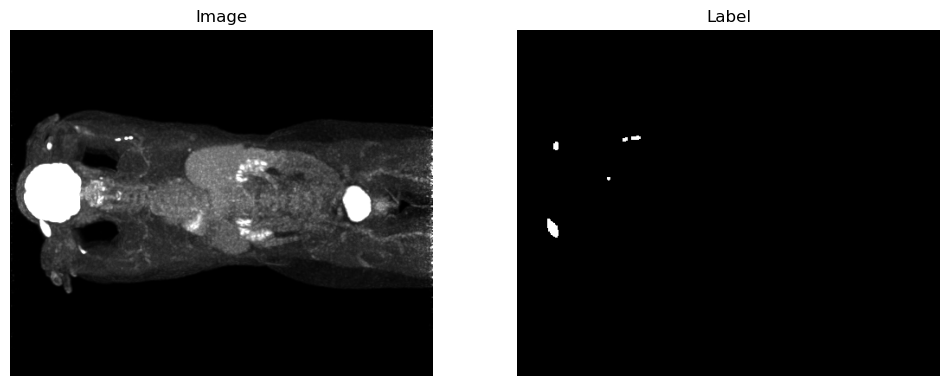

In [9]:
# random flip

random_flip = tio.RandomFlip(axes=['inferior-superior'], flip_probability=1)
subject_flip = random_flip(one_subject)

plot_example(subject_flip['img'][tio.DATA].squeeze().numpy()[slice_idx, :, :],
                subject_flip['label'][tio.DATA].squeeze().numpy()[slice_idx, :, :])

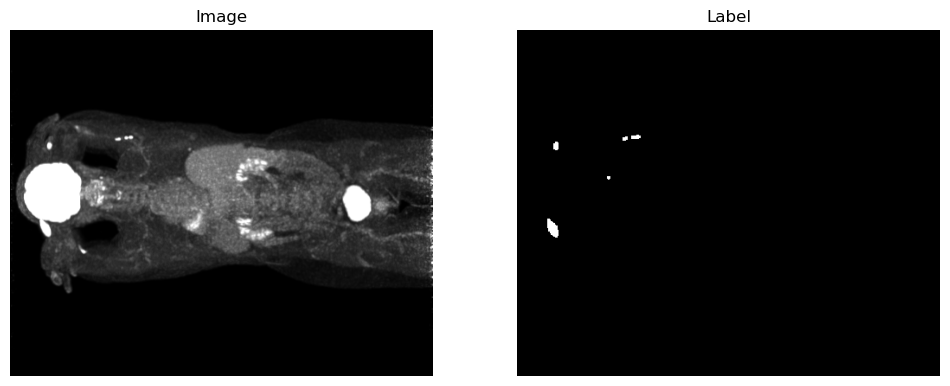

In [10]:
# random elastic deformation

max_displacement = 5, 5, 0
max_control_points = 5

random_elastic = tio.RandomElasticDeformation(max_displacement=max_displacement, num_control_points=max_control_points)
subject_elastic = random_elastic(one_subject)

plot_example(subject_elastic['img'][tio.DATA].squeeze().numpy()[slice_idx, :, :],
                subject_elastic['label'][tio.DATA].squeeze().numpy()[slice_idx, :, :])

## Intensity Transforamtions

In [11]:
# check if there are nans or infs in the data or values outside of the range

def check_nans_and_range(subject):
    image = subject['img'][tio.DATA]
    label = subject['label'][tio.DATA]
    print('Image has NaNs:', torch.isnan(image).any())
    print('Image has Infs:', torch.isinf(image).any())
    print('Image min:', image.min())
    print('Image max:', image.max())
    print('Label has NaNs:', torch.isnan(label).any())
    print('Label has Infs:', torch.isinf(label).any())
    print('Label min:', label.min())
    print('Label max:', label.max())

check_nans_and_range(one_subject)




Image has NaNs: tensor(False)
Image has Infs: tensor(False)
Image min: tensor(0, dtype=torch.uint8)
Image max: tensor(255, dtype=torch.uint8)
Label has NaNs: tensor(False)
Label has Infs: tensor(False)
Label min: tensor(0, dtype=torch.uint8)
Label max: tensor(255, dtype=torch.uint8)


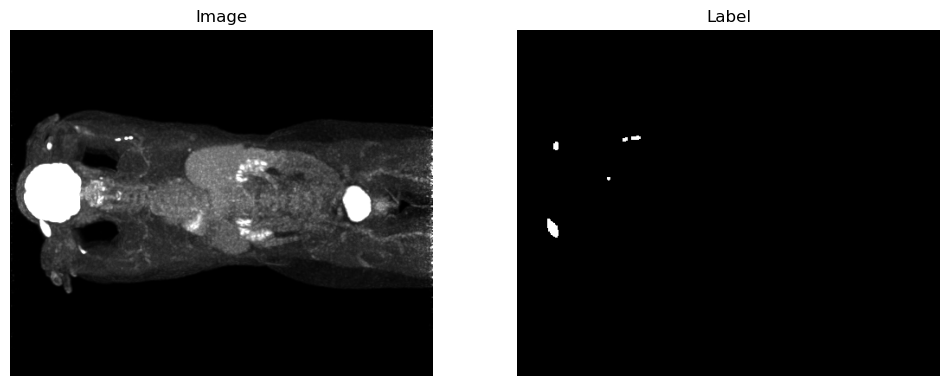

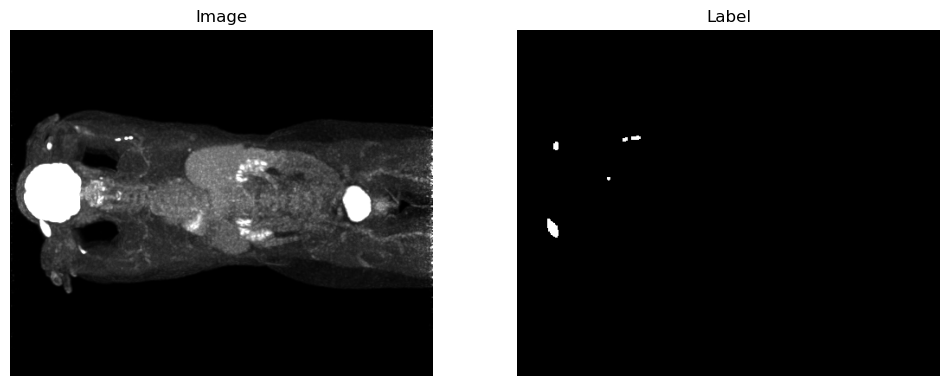

/home/asp/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/asp/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/asp/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/asp/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

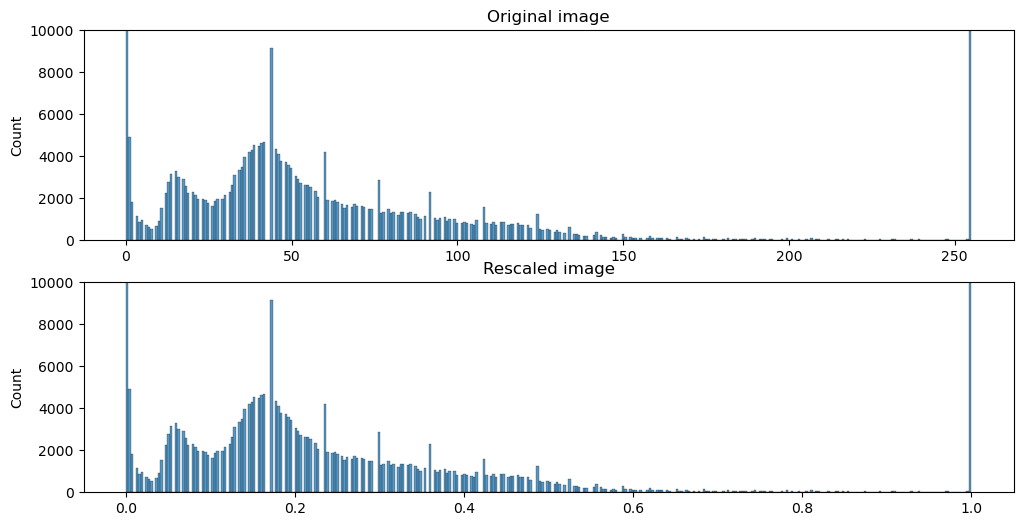

In [12]:
# rescale intensity



rescale_intensity = tio.RescaleIntensity((0, 1), percentiles=(1, 99))
subject_rescale = rescale_intensity(one_subject)
#plot original and rescaled image
plot_example(one_subject['img'][tio.DATA].squeeze().numpy()[slice_idx, :, :],
                one_subject['label'][tio.DATA].squeeze().numpy()[slice_idx, :, :])
plot_example(subject_rescale['img'][tio.DATA].squeeze().numpy()[slice_idx, :, :],
                subject_rescale['label'][tio.DATA].squeeze().numpy()[slice_idx, :, :])

# histogram
fig, axes = plt.subplots(2, 1, figsize=(12, 6))
sns.histplot(one_subject['img'][tio.DATA].squeeze().numpy().flatten(), ax=axes[0])
sns.histplot(subject_rescale['img'][tio.DATA].squeeze().numpy().flatten(), ax=axes[1])
axes[0].set_title('Original image')
axes[0].set_ylim(0, 10000)
axes[1].set_title('Rescaled image')
axes[1].set_ylim(0, 10000)
plt.show()

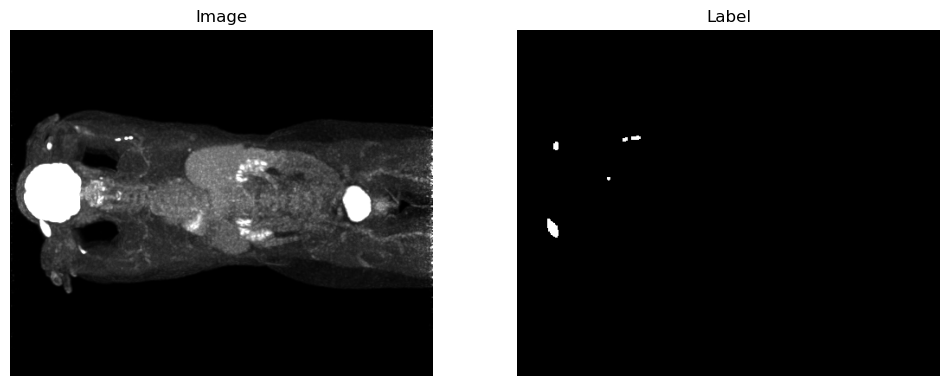

/home/asp/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/asp/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/asp/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/asp/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

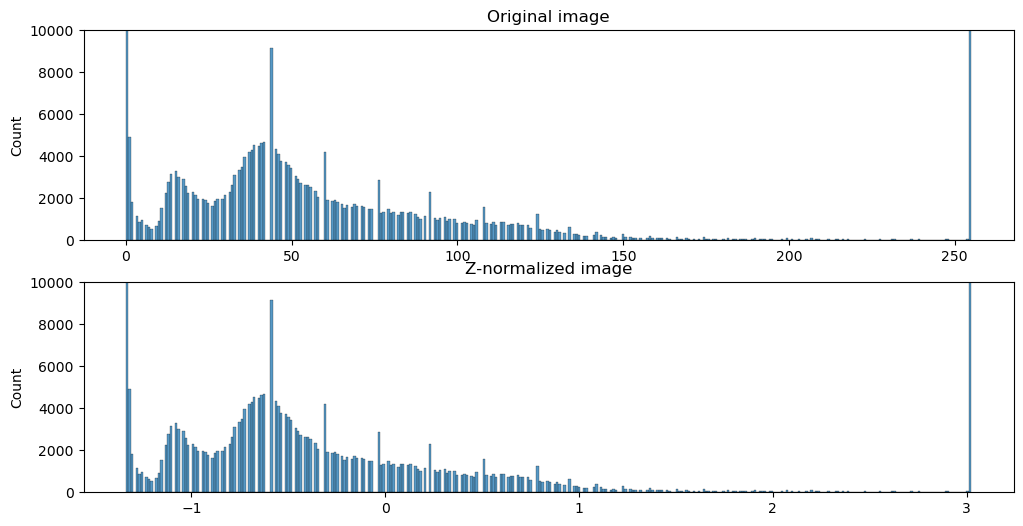

In [13]:
# z normalization

z_normalization = tio.ZNormalization(masking_method=tio.ZNormalization.mean)
subject_znorm = z_normalization(one_subject)

plot_example(subject_znorm['img'][tio.DATA].squeeze().numpy()[slice_idx, :, :],
                subject_znorm['label'][tio.DATA].squeeze().numpy()[slice_idx, :, :])

# histogram
fig, axes = plt.subplots(2, 1, figsize=(12, 6))
sns.histplot(one_subject['img'][tio.DATA].squeeze().numpy().flatten(), ax=axes[0])
sns.histplot(subject_znorm['img'][tio.DATA].squeeze().numpy().flatten(), ax=axes[1])
axes[0].set_title('Original image')
axes[0].set_ylim(0, 10000)
axes[1].set_title('Z-normalized image')
axes[1].set_ylim(0, 10000)
plt.show()


# TODO: It might be possible to rescale the histogram. This way some properties might be better visible than others

## Augmentation

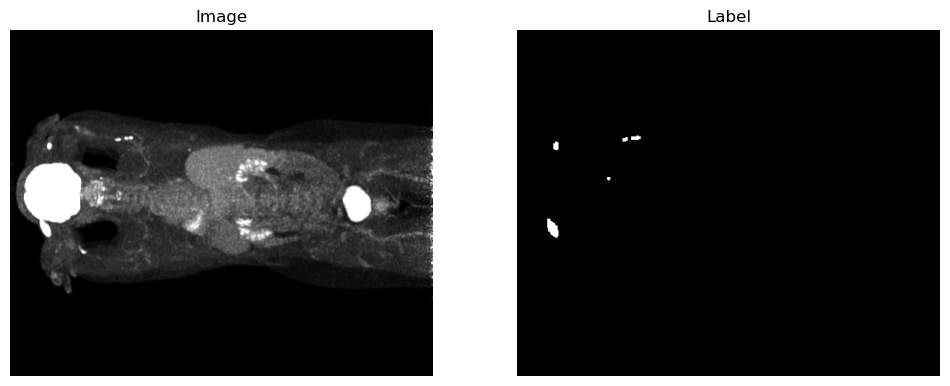

In [23]:
# blur

blur = tio.RandomBlur(std=(0,1))
subject_blur = blur(subject_znorm)

plot_example(subject_blur['img'][tio.DATA].squeeze().numpy()[slice_idx, :, :],
                subject_blur['label'][tio.DATA].squeeze().numpy()[slice_idx, :, :])
                

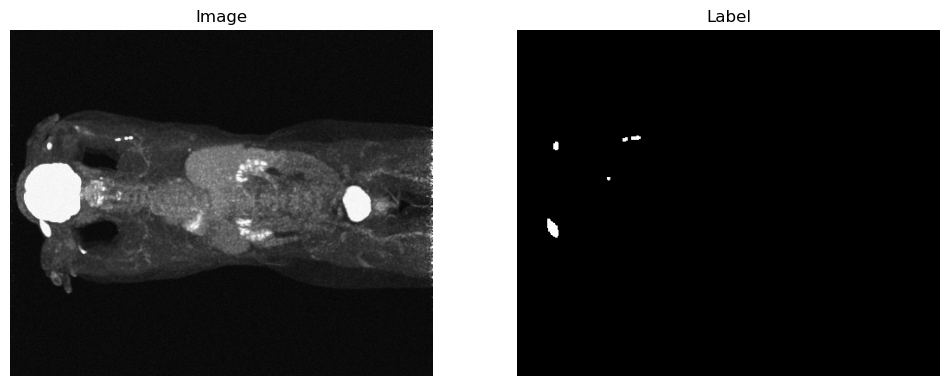

In [19]:
# random noise

noise = tio.RandomNoise(std=(0.05)) # do znormalization first!!!
subject_noise = noise(subject_znorm)

plot_example(subject_noise['img'][tio.DATA].squeeze().numpy()[slice_idx, :, :],
                subject_noise['label'][tio.DATA].squeeze().numpy()[slice_idx, :, :])



## Medical images specific transformations

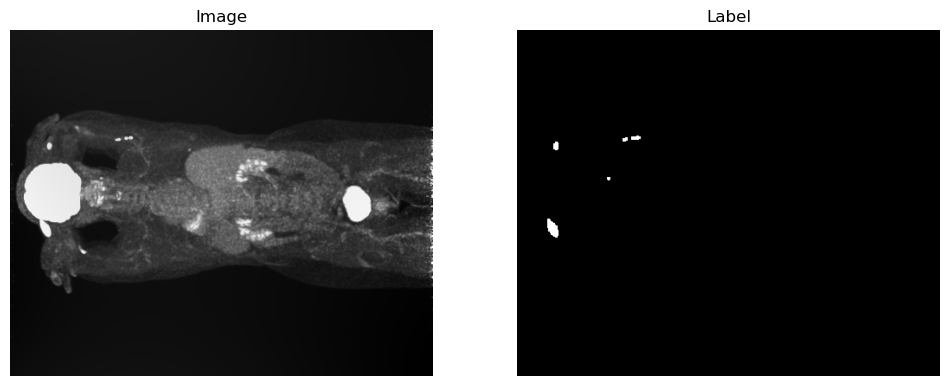

In [16]:
#random bias

bias = tio.RandomBiasField(coefficients=.1)
subject_bias = bias(subject_znorm)

plot_example(subject_bias['img'][tio.DATA].squeeze().numpy()[slice_idx, :, :],
                subject_bias['label'][tio.DATA].squeeze().numpy()[slice_idx, :, :])


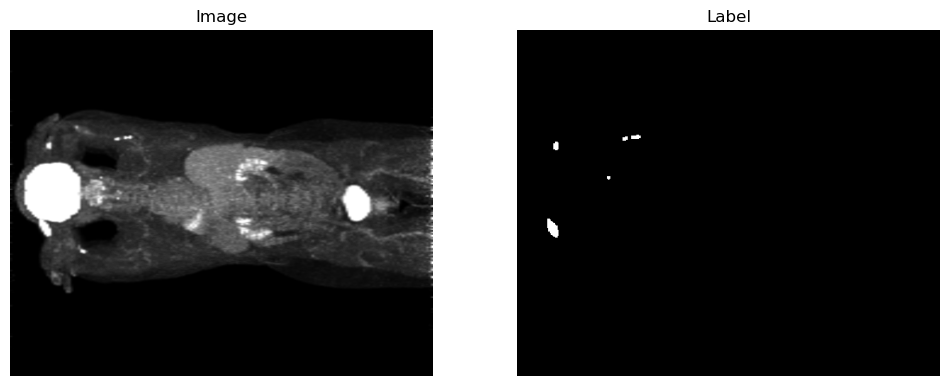

In [17]:
#several transforms

transform = tio.Compose([
    anisotropy,
    random_elastic,
])
subject_transform = transform(one_subject)

plot_example(subject_transform['img'][tio.DATA].squeeze().numpy()[slice_idx, :, :],
                subject_transform['label'][tio.DATA].squeeze().numpy()[slice_idx, :, :])
    

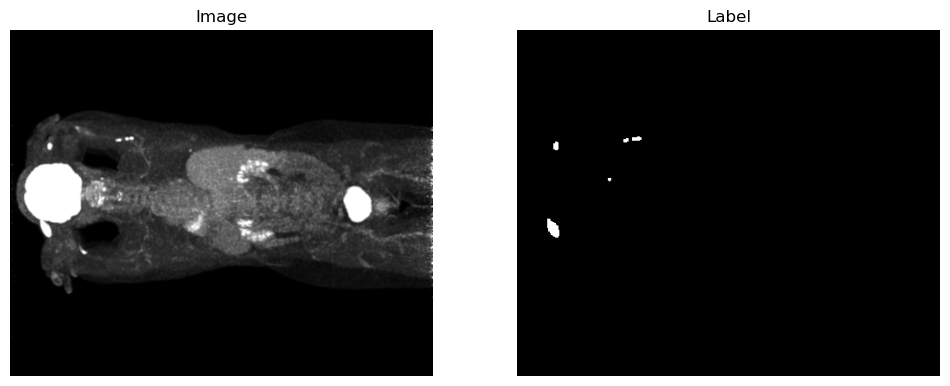

In [18]:
# one of

spatial_transform = tio.OneOf({
    random_affine,
    random_elastic,
    random_flip,
})
subject_spatial = spatial_transform(one_subject)

plot_example(subject_spatial['img'][tio.DATA].squeeze().numpy()[slice_idx, :, :],
                subject_spatial['label'][tio.DATA].squeeze().numpy()[slice_idx, :, :])

